# ANN to Predict a Single Emotion
Using modal representation, can we imrprove on Santamaria-Granados, Luz, et al. "Using deep convolutional neural network for emotion detection on a physiological signals dataset (AMIGOS)." IEEE Access 7 (2018): 57-67.

Another step forward from fingerprints, single subject??

Setup: Javascript and ipynb stuff

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## Load Functions

In [1]:
from fastai.vision import *
import os
import numpy as np
import pandas as pd
import pickle
import warnings; warnings.simplefilter('ignore')

In [2]:
path=pathlib.Path('/home/tris/Documents/EEG_data/DMD_DEAP')
path

PosixPath('/home/tris/Documents/EEG_data/DMD_DEAP')

## Load Original Data Labels

In [34]:
path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s01.dat'
df_read = pickle.load(open(path, 'rb'), encoding='latin1')
labels=df_read['labels']
df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
df=df_tmp
for n in range (2,10):
    path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s0'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True)
for n in range (10,33):
    path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True) 

In [35]:
df=df.div(9) #normalize
df.head()

,valence,arousal,dominance,liking
0,0.856667,0.844444,0.766667,0.870000
1,0.900000,0.812222,0.808889,0.941111
2,0.953333,0.837778,1.000000,0.786667
3,0.548889,0.667778,0.680000,0.895556
4,0.773333,0.435556,0.798889,0.672222


## Set filenames and labels

In [36]:
filenames=[]
subject_labels=[]
for n in range (0,9):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
    for i in range (9,40):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
for n in range (9,32):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
    for i in range (9,40):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
df['file_name']=filenames
df['subject_label']=subject_labels
df=df[['file_name','subject_label','valence','arousal']]
df.tail()

,file_name,subject_label,valence,arousal
1275,S32T36,32,0.434444,0.773333
1276,S32T37,32,0.312222,0.681111
1277,S32T38,32,0.338889,0.778889
1278,S32T39,32,0.443333,0.796667
1279,S32T40,32,0.794444,0.447778


In [37]:
# for i in range(1,33):
#     for ii in range(1,41):
#         os.rename(r'/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/T'+str(ii)+'S'+str(i)+".png",r'/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/S'+str(i)+'T'+str(ii)+".png")

In [38]:
# from PIL import Image

# for i in range (0,1280):
    
#     im = Image.open(r"/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/"+str(df.file_name[i])+".png")
#     im1=im.crop((0,0,1450,1030))
#     im1.save("/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps_re/"+str(df.file_name[i])+".png")

In [39]:
df.loc[(df['valence'] >= 0.5) & (df['arousal'] >= 0.5), 'emotion_quad'] = 0  #HVHA
df.loc[(df['valence'] <= 0.5) & (df['arousal'] >= 0.5), 'emotion_quad'] = 1  #LVHA
df.loc[(df['valence'] <= 0.5) & (df['arousal'] <= 0.5), 'emotion_quad'] = 2 #LVLA  
df.loc[(df['valence'] >= 0.5) & (df['arousal'] <= 0.5), 'emotion_quad'] = 3  #HVLA
df.head()

,file_name,subject_label,valence,arousal,emotion_quad
0,S1T1,1,0.856667,0.844444,0.0
1,S1T2,1,0.900000,0.812222,0.0
2,S1T3,1,0.953333,0.837778,0.0
3,S1T4,1,0.548889,0.667778,0.0
4,S1T5,1,0.773333,0.435556,3.0


In [40]:
# df.loc[(df['valence'] >= 0.5) & (df['arousal'] >= 0.5), 'emotion_quad'] = 'HVHA'  #HVHA
# df.loc[(df['valence'] <= 0.5) & (df['arousal'] >= 0.5), 'emotion_quad'] = 'LVHA'  #LVHA
# df.loc[(df['valence'] <= 0.5) & (df['arousal'] <= 0.5), 'emotion_quad'] = 'LVLA' #LVLA  
# df.loc[(df['valence'] >= 0.5) & (df['arousal'] <= 0.5), 'emotion_quad'] = 'HVLA'  #HVLA
# df.head()

In [41]:
df=df.tail(n=40);
df=df.reset_index(drop=True); df

,file_name,subject_label,valence,arousal,emotion_quad
0,S32T1,32,0.903333,0.536667,0.0
1,S32T2,32,0.554444,0.332222,3.0
2,S32T3,32,0.894444,0.787778,0.0
3,S32T4,32,0.773333,0.571111,0.0
4,S32T5,32,0.794444,0.660000,0.0
5,S32T6,32,0.642222,0.443333,3.0
6,S32T7,32,0.548889,0.454444,3.0
7,S32T8,32,0.884444,0.673333,0.0
8,S32T9,32,0.873333,0.463333,3.0
9,S32T10,32,0.453333,0.661111,1.0


![GitHub Logo](https://www.researchgate.net/profile/Fadi_Al_Machot/publication/307587787/figure/fig3/AS:572907778318337@1513603266552/Arousal-valence-based-emotional-states.png)

In [42]:
path=pathlib.Path('/media/tris/tris_files/EEG_datasets/DMD')
path

PosixPath('/media/tris/tris_files/EEG_datasets/DMD')

In [43]:
df.to_csv(path/'labels_proc_S32.csv', index=False)

In [44]:
df = pd.read_csv(path/'labels_proc_S32.csv') #load labels
df.tail()

,file_name,subject_label,valence,arousal,emotion_quad
35,S32T36,32,0.434444,0.773333,1.0
36,S32T37,32,0.312222,0.681111,1.0
37,S32T38,32,0.338889,0.778889,1.0
38,S32T39,32,0.443333,0.796667,1.0
39,S32T40,32,0.794444,0.447778,3.0


## Data loader

In [45]:
path=pathlib.Path('/media/tris/tris_files/EEG_datasets/DMD')
df = pd.read_csv(path/'labels_proc_S32.csv') #load labels
df.tail()

,file_name,subject_label,valence,arousal,emotion_quad
35,S32T36,32,0.434444,0.773333,1.0
36,S32T37,32,0.312222,0.681111,1.0
37,S32T38,32,0.338889,0.778889,1.0
38,S32T39,32,0.443333,0.796667,1.0
39,S32T40,32,0.794444,0.447778,3.0


In [46]:
src = (ImageList.from_csv(path, 'labels_proc_S32.csv', folder='heatmaps_32ch', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(cols=['emotion_quad'],label_cls=CategoryList))

In [47]:
tfms=[]

In [48]:
data = (src.transform(tfms, size=300)
        .databunch(bs=4).normalize())

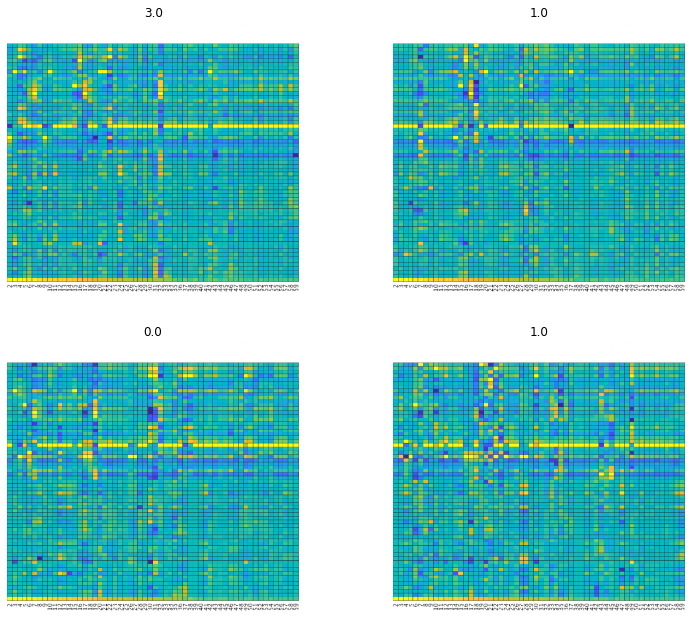

In [49]:
data.show_batch(rows=4, figsize=(12,9))

## Setup Network

In [50]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [51]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
ReLU                 [64, 75, 75]         0          False     
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


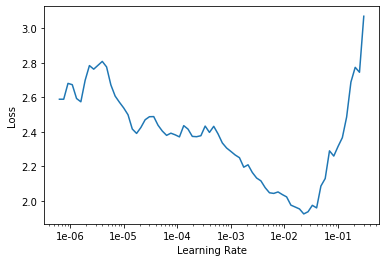

In [52]:
learn.lr_find()
learn.recorder.plot()

## Train last layers

In [53]:
lr = 3e-3
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.573149,2.123598,0.125000,00:01
1,2.261927,1.768502,0.250000,00:01
2,1.986845,0.953477,0.500000,00:01
3,1.804318,1.160074,0.375000,00:01
4,1.605411,1.601744,0.375000,00:01
5,1.351363,1.699369,0.500000,00:01
6,1.130190,1.567011,0.375000,00:01
7,0.987020,1.685501,0.500000,00:01
8,0.909326,1.683895,0.500000,00:01
9,0.849244,1.699296,0.625000,00:01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3563025950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f35630bbc90>]], dtype=object)

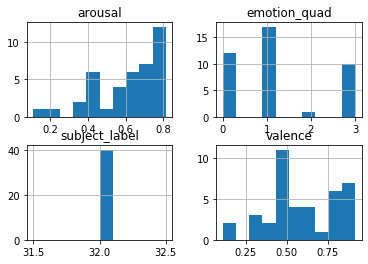

In [54]:
df.hist()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-5
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.show_results()

## Train the whole network

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 2e-5
learn.fit_one_cycle(10, slice(lr))

## Interpret and Results

In [ ]:
learn.show_results()

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
interp.plot_top_losses(4)

In [ ]:
idx=5
x,y = data.valid_ds[idx]
x.show()

In [ ]:
m = learn.model.eval();
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm,filename):
    _,ax = plt.subplots(figsize=(20,10))
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.7, extent=(0,200,200,0), #this is werid with resize...
              interpolation='bilinear', cmap='magma');
    plt.savefig(filename)

In [ ]:
# show_heatmap(avg_acts,'test.png')

In [ ]:
# for idx in range(0,200):
#     x,y = src.valid_ds[idx]
#     xb,_ = src.one_item(x)
#     xb_im = Image(src.denorm(xb)[0])
#     xb = xb.cuda()
#     hook_a,hook_g = hooked_backward()
#     acts  = hook_a.stored[0].cpu()
#     avg_acts = acts.mean(0)
#     filename='heatmap_'+str(idx)+'.png'
#     show_heatmap(avg_acts,filename)
    